# **Fourier Series and spectra**

With *Fourier series*, we can approximate a periodic function $x(t)$ as a weighted summation of sinusoidal basis functions. 

$$ x(t) \approx A_0 + \sum_{k=1}^N \left(A_k\cos(\omega_k t + \varphi_k) \right)$$

This decomposition allows us to analyze a signal in terms of its frequency components, which is fundamental in many applications, such as spectral filtering, image compression, and solving partial differential equations.

Note that, in addition to the Fourier series, there are other types of series expansions. In a *Taylor series*, the basis functions are polynomials of increasing order. In a *wavelet series*, the basis functions are wavelets—special functions that are localized in both time and frequency. What this means in practice, we will explore later in the course.

For now, we will focus entirely on the Fourier series. Let’s get started!

## **Exercises**
* [Exercise 1 – Periodic signals](#exercise1)  
* [Exercise 2a – Compute Fourier series](#exercise2a)
* [Exercise 2b – Look up Fourier coefficients](#exercise2b)  
* [Exercise 3 – Spectrum](#exercise3)  
* [Exercise 4 – Inverse Fourier / signal reconstruction](#exercise4)  
* [Exercise 5 – Fourier spectrum using FFT](#exercise5)  
* [Exercise 6 – Fourier and aliasing](#exercise6)  

---

## **Preparations**

Let's start with the usual preparatory steps...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.fft import fft, ifft, fftfreq, fftshift

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

import sys
sys.path.insert(0, "../")
import isp

---

<a id='exercise1'></a>

## **&#9734;  Exercise 1 – Periodic signals**

In the lectures, we have explored various periodic functions $x(t)$, such as the sawtooth and pulse functions.

The [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html#waveforms) module provides already built-in support for generating several types of waveforms. 
 

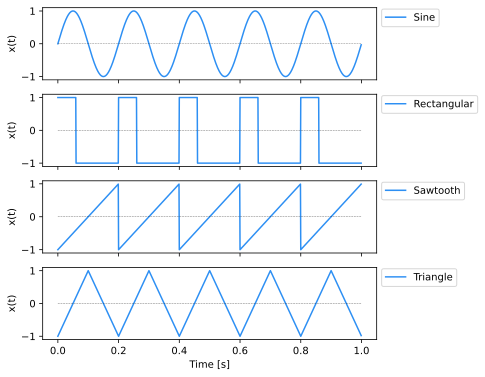

In [2]:
from scipy import signal

# Illustration of different waveforms offered by numpy and scipy.signal:
duration = 1    # seconds
f_signal = 5    # Hz
f_sample = 1000 # Hz

t = np.arange(0, duration, 1/f_sample)

# Sine wave
x_sine = np.sin(2 * np.pi * f_signal * t)
x_rect = signal.square(2 * np.pi * f_signal * t, duty=0.3)
x_sawtooth = signal.sawtooth(2 * np.pi * f_signal * t)
x_triangle = signal.sawtooth(2 * np.pi * f_signal * t, width=0.5)

# Decorate the plot
def decorate(ax):
    ax.set_ylabel("x(t)")
    # Add legend outside of the plot
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1.05))
    # Add a zero line
    ax.plot([0, duration], [0, 0], "k--", lw=0.5, alpha=0.5)

# Plot
fig, axes = plt.subplots(4, 1, figsize=(6, 6), sharex=True)
axes[0].plot(t, x_sine, label="Sine")
axes[1].plot(t, x_rect, label="Rectangular")
axes[2].plot(t, x_sawtooth, label="Sawtooth")
axes[3].plot(t, x_triangle, label="Triangle")
for ax in axes:
    decorate(ax)
# Only for last ax:
ax.set_xlabel("Time [s]");


Your task is to construct these signals using only NumPy or basic Python operations.

### **Instructions**
* Complete the following functions.
* Visualize the results to verify correctness.
* Hints:
  * The modulo operation `t%T` computes the remainder when dividing `t` by `T`. This can also be used for an array of values `t`.
  * The modulo operation `t%T` computes the remainder of `t` divided by `T`. When applied to an array `t`, it operates element-wise.
  * [`np.where(cond, x, y)`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) assigns a value `x` if condition `cond` is True, and `y` otherwise.

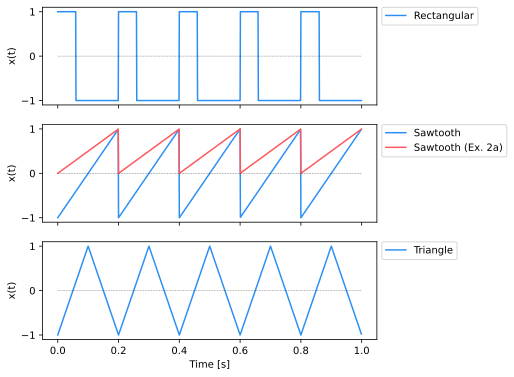

In [9]:
def rectangular_wave(t, f, duty=0.5, amplitude=1, offset=0.):
    """Generate a rectangular wave.

    Parameters
    ----------
    t : array_like      Time vector
    f : float           Frequency of the wave
    duty : float        Duty cycle of the wave
    amplitude : float   Amplitude of the wave
    """
    t_period = 1 / f
    t_duty = t_period * duty
    return np.where((t % t_period) < t_duty, 1, -1) * amplitude + offset


def sawtooth_wave(t, f, amplitude=1, offset=0):
    """Generate a sawtooth wave.

    Parameters
    ----------
    t : array_like      Time vector
    f : float           Frequency of the wave
    amplitude : float   Amplitude of the wave
    """
    t_period = 1 / f
    return 2 * (t % t_period) / t_period * amplitude - amplitude + offset


def triangle_wave(t, f, amplitude=1, offset=0):
    """Generate a triangle wave.

    Parameters
    ----------
    t : array_like      Time vector
    f : float           Frequency of the wave
    amplitude : float   Amplitude of the wave
    """
    t_period = 1 / f
    return -2 * np.abs(2 * (t % t_period) / t_period - 1) * amplitude + amplitude + offset


t = np.arange(0, duration, 1/f_sample)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axes[0].plot(t, rectangular_wave(t, f_signal, duty=0.3), label="Rectangular")
axes[1].plot(t, sawtooth_wave(t, f_signal), label="Sawtooth")
axes[1].plot(t, sawtooth_wave(t, f_signal, offset=0.5, amplitude=0.5), label="Sawtooth (Ex. 2a)")
axes[2].plot(t, triangle_wave(t, f_signal), label="Triangle")
for ax in axes:
    decorate(ax)
# Only for last ax:
ax.set_xlabel("Time [s]");

---

<a id='exercise2a'></a>

## **&#9734;&#9734;  Exercise 2a – Compute Fourier series**

In the lecture, we introduced the procedure for calculating Fourier coefficients. The following formulas are fundamental

$$\begin{align*} 
a_0&= \frac{1}{T}\int_{-T/2}^{T/2} x(t)\,dt\\
a_k &= \frac{2}{T}\int_{-T/2}^{T/2} x(t) \cos \left( 2\pi \tfrac{k}{T} t \right) \,dt\qquad\text{for } k\geq 1\qquad\\
b_k &= \frac{2}{T}\int_{-T/2}^{T/2} x(t) \sin \left( 2\pi \tfrac{k}{T} t \right) dt\qquad\text{for } k\geq 1
\end{align*}
$$

These integrals allow us to compute the Fourier series coefficients (in sine-cosine form), which characterize a function in terms of its frequency components. 

### **Example: Fourier Series of a square wave**
Let's apply these formulas to a square wave (a rectangular wave with duty cycle = 0.5). Since the Fourier transform only considers one period at a time, we define:

$$
x(t) = \begin{cases} -1 & \text{if } &-\frac{T}{2} \leq t < 0 
\\ +1 & \text{if }  &0 \leq t < \frac{T}{2} \end{cases} $$

It is important to note that the choice of period interval has no influence on the result. The integrals could also be evaluated using $0 \leq t \leq T$, for example. 


#### **Coefficient $a_0$ (DC component)**

$$
\begin{align*}
a_0 &= \frac{1}{T}\left(\int_{-T/2}^0 (-1)\,dt + \int^{T/2}_0 (+1)\,dt\right)\\
&= \frac{1}{T}\left(-t\,\bigg\rvert_{-T/2}^0 + t\,\bigg\rvert_{0}^{T/2}\right)\\
&= 0
\end{align*}
$$

The term $a_0$​ represents the DC component (the average value of the signal). Since the square wave is symmetric around zero, the average value is indeed zero. 


#### **Coefficient $a_k$ (cosine coefficients)**

$$
\begin{align*}
a_k &= \frac{2}{T}\left(\int_{-T/2}^0 (-1)\cos\left(\tfrac{2\pi k}{T}t\right) \,dt + \int^{T/2}_0 (+1)\cos\left(\tfrac{2\pi k}{T}t\right)\,dt\right)\\
&= -\frac{2}{T}\frac{T}{2\pi k}\sin\left(\frac{2\pi k}{T}t\right)\,\bigg\rvert_{-T/2}^0 + 
\frac{2}{T}\frac{T}{2\pi k}\sin\left(\frac{2\pi k}{T}t\right)\,\bigg\rvert_{-T/2}^0\\
 &= 0
\end{align*}
$$

All coefficients $a_k$  are zero because the square wave is an odd function, while cosine functions are even. The $a_k$ contribute only to the *even* components in the signal, which are not present in the square wave signal. 


#### **Coefficient $b_k$ (sine coefficients)**


$$
\begin{align*}
b_k &= \frac{2}{T}\left(\int_{-T/2}^0 (-1)\sin\left(\tfrac{2\pi k}{T}t\right) \,dt + \int^{T/2}_0 (+1)\sin\left(\tfrac{2\pi k}{T}t\right)\,dt\right) \\
&= \frac{2}{T}\frac{T}{2\pi k}\cos\left(\frac{2\pi k}{T}t\right)\,\bigg\rvert_{-T/2}^0 
- \frac{2}{T}\frac{T}{2\pi k}\cos\left(\frac{2\pi k}{T}t\right)\,\bigg\rvert_0^{T/2} \\[1em]
&= \frac{1}{\pi k}(\cos(0)- \cos(-\pi k)) - \frac{1}{\pi k}(\cos(\pi k)- \cos(0))\\[0.75em]
&= \frac{1}{\pi k}(1 - \cos(+\pi k)) - \frac{1}{\pi k}(\cos(\pi k)- 1)\\[0.75em]
&= \begin{cases} 0, & k\text{ even}\\
\frac{4}{\pi k}, & k\text{ odd}
\end{cases}
\end{align*}
$$

In the last lines, we used the following facts:
* $\cos(-t)=\cos(t)$
* $\cos({\pi k})=(-1)^k$ 

Thus, the square wave consists only of sine terms with odd harmonic frequencies.

<br>

### **Instructions**
* Try to follow the derivation and understand why certain coefficients vanish.
* For the brave ones only: Repeat the process for a sawtooth wave.

- check out solution


---

<a id='exercise2b'></a>

## **&#9734;  Exercise 2b – Look up Fourier coefficients**

Alternatively, instead of deriving the Fourier coefficients manually, we can look up the coefficients for special functions $x(t)$ in a formulary.

### **Instructions**
* Search the web for the Fourier series coefficients of 
  * the *rectangular wave*, 
  * the *sawtooth wave* and 
  * the *triangular wave*.
* Use the *sine-cosine form* of the Fourier series!
* Make sure to really match the function $x(t)$ that we introduced above!


```lang-none
######################
###    EXCERISE    ###
######################
````

Type here your solution.

<br>

***Formulas for rectangular wave***

$
\begin{aligned}
a_0 &= A\cdot(2\cdot r-1)+q\\[0.3em]
a_k &= \tfrac{2A}{\pi k}\sin(2\pi k r)\\[0.3em]
b_k &= \tfrac{2A}{\pi k}\left(1-\cos(2\pi k r)\right)
\end{aligned}
$

<br>

***Formulas for sawtooth wave***

$
\begin{aligned}
a_0 &= q\\[0.3em]
a_k &= 0\\[0.2em]
b_k &= -\tfrac{2A}{\pi k}
\end{aligned}
$

<br>

***Formulas for traingular wave***


$
\begin{aligned}
a_0 &= A+q\\[0.3em]
a_k &= -\tfrac{8A}{\pi^2k^2}\\[0.3em]
b_k &= 0
\end{aligned}
$

---

<a id='exercise3'></a>

## **&#9734;  Exercise 3 – Spectrum**

The **amplitude spectrum** of a signal describes how strongly the harmonics (integer multiples of the fundamental frequency $f=1/T$​) contribute to the signal. It provides insight into the amplitude distribution of the signal in the frequency domain.

The phase spectrum, on the other hand, indicates the relative phase shifts of these harmonics, determining their position in the time domain.

In the previous exercise, we determined the Fourier coefficients of periodic signals (rectangular, sawtooth, triangular) using the sine-cosine form. To compute the magnitude (amplitude) and phase of the spectrum, we use the following conversion formulas:


$$
\begin{align*}
A_k &= \sqrt{a_k^2 + b_k^2} \\[0.5em]
\varphi_k&=\arctan{\left(\frac{b_k}{a_k}\right)}
\end{align*}
$$


### **Instructions**
* First answer this conceptual question: What are the angular frequencies $\omega_k$ associated with the Fourier coefficients?
* Given the expressions for $a_k, b_k$:
  * Plot the magnitude spectrum $A_k$
  * Plot the phase spectrum $\varphi_k$
  * Use [`plt.stem()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.stem.html) to visualize the discrete spectrum

Use a square wave with a period of one second as the example signal.

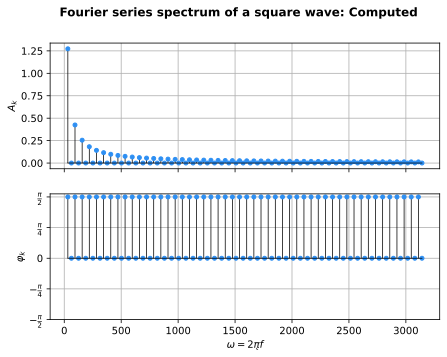

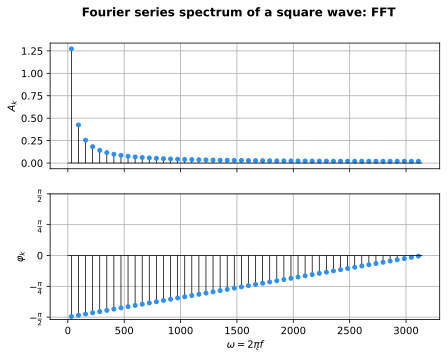

In [10]:
######################
###    Exercise   ###
######################

# Define Fourier series coefficients for a square wave (see exercise 2)
def get_a0(): return 0
def get_ak(k): return np.zeros_like(k)
def get_bk(k): return np.where(k%2 != 0, 4 / (np.pi * k), 0) 

# Define signal parameters
duration = 1     # Duration of the signal (seconds)
f_signal = 5     # Frequency of the signal (Hz)
f_sample = 1000  # Sampling frequency (Hz)
t = np.arange(0, duration, 1/f_sample)

# Compute Fourier series coefficients
N = 100
k = np.arange(1, N+1)
aks = get_ak(k)
bks = get_bk(k)
omega = 2 * np.pi * k * f_signal

# Compute magnitude and phase spectrum
Ak = np.sqrt(aks**2 + bks**2)
phase_k = np.arctan2(bks, aks)

# For comparison, we compute also the spectrum using the FFT
from scipy.fft import rfft, rfftfreq, fftshift
xs = signal.square(2 * np.pi * f_signal * (t), duty=0.5)
T = 1/f_signal
# Compute FFT and shift spectrum
xf = rfft(xs, len(xs))
xf = fftshift(xf)
freqs = fftshift(rfftfreq(len(xs), 1/f_sample))*2*np.pi

# Scale the amplitude spectrum (this is expert knowledge): 
# - Divide by number of samples (because FFT is "energy preserving")
# - Multiply by 2 (because we only have half of the spectrum with RFFT)
xf_amp = np.abs(xf) / len(xs) * 2 
xf_phase = np.angle(xf)

# Remove numerical noise for very small amplitudes
xf_phase[xf_amp < 1e-10] = np.nan
xf_amp[xf_amp < 1e-10] = np.nan

# Helper function for consistent plot styling
def apply_aesthetics(stem_ret):
    markerline, stemlines, baseline = stem_ret
    plt.setp(stemlines, "linewidth", 0.75, "color", "k")
    plt.setp(markerline, "marker", "o", "markersize", 4)
    plt.setp(baseline, "linewidth", 0.75, "color", "k")
    return stem_ret

# Plot Fourier Series Spectrum
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fig.suptitle("Fourier series spectrum of a square wave: Computed", 
             fontweight="bold")

ret = axes[0].stem(omega, Ak)
apply_aesthetics(ret)

ret = axes[1].stem(omega, phase_k)
apply_aesthetics(ret)

axes[0].set_ylabel(r"$A_k$")
axes[0].grid("on")
axes[1].set_ylabel(r"$\varphi_k$")
axes[1].set_yticks([-np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2])
axes[1].set_yticklabels([r"$-\frac{\pi}{2}$", 
                         r"$-\frac{\pi}{4}$", 
                         r"$0$", 
                         r"$\frac{\pi}{4}$", 
                         r"$\frac{\pi}{2}$"])
axes[1].set_xlabel(r"$\omega = 2\pi\k f$")
axes[1].grid("on")

# Compare with FFT spectrum for reference.
# (We will learn more about the FFT later in the course)
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fig.suptitle("Fourier series spectrum of a square wave: FFT", 
             fontweight="bold")

ret = axes[0].stem(freqs, xf_amp, label="FFT - Amplitude")
apply_aesthetics(ret)
ret = axes[1].stem(freqs, xf_phase, label="FFT - Phase")
apply_aesthetics(ret)
axes[0].set_ylabel(r"$A_k$")
axes[0].grid("on")
axes[1].set_ylabel(r"$\varphi_k$")
axes[1].set_yticks([-np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2])
axes[1].set_yticklabels([r"$-\frac{\pi}{2}$", 
                         r"$-\frac{\pi}{4}$", 
                         r"$0$", 
                         r"$\frac{\pi}{4}$", 
                         r"$\frac{\pi}{2}$"])
axes[1].set_xlabel(r"$\omega = 2\pi\k f$")
axes[1].grid("on")





<span style="color:gray">
Note the discrepancy between the phase computed with the Fast Fourier Transform (FFT) and the mathematically derived phase (±π/2) for a square wave. This arises from how the FFT processes discrete, finite-length signals. The mathematical Fourier series assumes an infinitely periodic function that is symmetrically centered around t=0. In contrast, the FFT operates on a finite segment of the signal, assuming it starts at t=0, which can introduce phase shifts.
<br>

**Take-home message**: While the FFT resembles the Fourier series, they are not the same. The Fourier series applies to continuous-time periodic signals, while the Discrete Fourier Transform (DFT) — which the FFT efficiently computes — applies to discrete-time, non-periodic signals. Although conceptually related, they have fundamental differences that impact the computed spectra.
</span>.


---

<a id='exercise4'></a>

## **&#9734;  Exercise 4 – Inverse Fourier / signal reconstruction**

A Fourier series can be used to approximate a periodic function $x(t)$ by summing a finite number of terms:

$$x(t) \approx a_0 + \sum_{k=1}^N a_k\cos\left(\tfrac{2\pi k}{T}t\right)$$

The more terms we include, the more accurately the approximation captures the original signal.

In this exercise, we will reconstruct the signal using a truncated Fourier series.

### **Instructions**
* Use the Fourier coefficients of the square wave (with period $T=1s$).
* Approximate $x(t)$ using the partial sum for $N=6$.  
  (This requires implementing the formula above.)
* Plot the original signal and compare it with its reconstructed version for $N=6$.
* Use a sampling frequency of $f_{recon} = 1000$ and a duration of 5 seconds for the reconstructed signal.

5000
5000


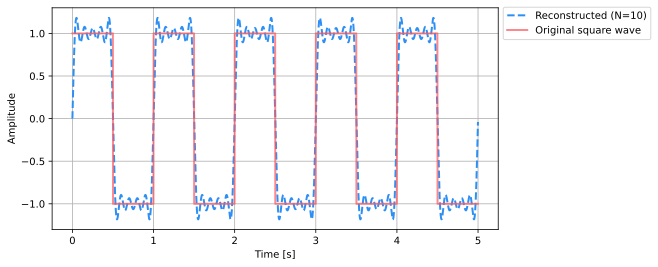

In [11]:
######################
###    EXERCISE    ###
######################
N = 10
T = 1
duration = 5
f_recon = 1000
k = np.arange(1, N+1)

# Define Fourier series coefficients for a square wave (see exercise 2)
def get_a0(): return 0
def get_ak(k): return np.zeros_like(k)
def get_bk(k): return np.where(k%2 != 0, 4 / (np.pi * k), 0) 

t = np.arange(0, duration, 1/f_recon)

a0 = get_a0()
ak = get_ak(k)
bk = get_bk(k)

# Reconstruct the signal using the truncated Fourier series
x_recon = a0 + np.sum([ak[i] * np.cos(2 * np.pi * (i+1) / T * t) +
                       bk[i] * np.sin(2 * np.pi * (i+1) / T * t)
                       for i in range(N)], axis=0)


# Generate the original square wave for comparison (see exercise 1)
x_orig = rectangular_wave(t, f=1, duty=0.5)

print(len(x_orig))
print(len(t))

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, x_recon, label="Reconstructed (N=%d)" % N, linewidth=2, linestyle="--")
ax.plot(t, x_orig, label="Original square wave", alpha=0.7, linewidth=2)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1.025))
ax.grid(True)
plt.show()

---

<a id='exercise5'></a>

## **&#9734;  Exercise 5 – Fourier spectrum using FFT**

A little preview: We can compute discrete Fourier transforms for (almost) any discrete signal using the Fast Fourier Transform (FFT) algorithm. We will explore this in more detail in upcoming lectures, but for now, we will already use it in the context of Fourier series.

### **Instructions**
- First: Skim through [the Scipy tutorial on FFTs](https://docs.scipy.org/doc/scipy/tutorial/fft.html). Do you understand the main differences to Fourier series?
- Create a composite signal with the following characteristics:
  - (At least) three harmonic components with frequencies (10, 100, 200)Hz
  - Amplitudes (2, 1.5, 3)
  - with a DC component of amplitude = 2
- Use a sampling frequency of $f_s=1$ kHz to construct the signal
- Compute the Fourier spectrum of this composite signal. Here is the procedure:
    1. Compute the `fft` by passing the signal: `X = fft(x)`  
      This creates the discrete Fourier transform $X[k] = \mathcal{F}(x(t)$)
    2. Compute the corresponding frequencies $\omega_k$ using `freqs = fftfreq(N, 1/fs)`.  
    We need to specify the number of samples $N$, and the sampling period $\Delta t = 1/f_s$.
    3. For practical reasons, the frequencies are sorted slightly awkwardly. Calling `fftshift()` on both the Fourier transform `X` and the frequencies `freqs`, fixes this.
- Visualize the Fourier spectrum
    - Plot the full (symmetric) spectrum, ensuring the frequency and amplitude axes are correctly labeled.
    - Separate amplitude and phase plots to analyze signal properties.
- Advanced task: 
    - Add random noise with an amplitude of 0.5 to the composite signal.
    - Compute and visualize the Fourier spectrum of the noisy signal.
    - Display only the positive frequencies (use rfftfreq() for this).
    - Compare and discuss the differences in the spectra before and after adding noise.


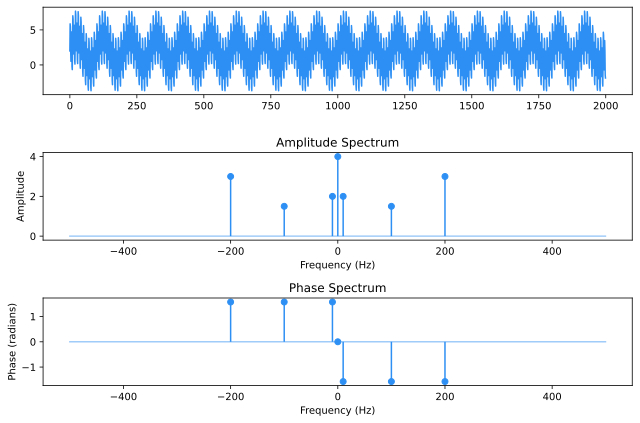

Ellipsis

In [12]:
######################
###    EXERCISE    ###
######################

# Define parameters
duration = 2  # Signal duration in seconds
fs = 1000     # Sampling frequency
t = np.arange(0, duration, 1/fs)  # Time vector
t = np.linspace(0.0, duration, fs*duration, endpoint=False)  # Time vector

# Note: The previous two lines are equivalent. Do you 
N = len(t)  # Number of samples

# Generate composite signal
f1 = 10  # Frequency of first harmonic (in Hz)
f2 = 100  # Frequency of second harmonic (in Hz)
f3 = 200  # Frequency of third harmonic (in Hz)

x = 2 + (
     2.0*np.sin(2 * np.pi * f1 * t) +
     1.5*np.sin(2 * np.pi * f2 * t) +
     3.0*np.sin(2 * np.pi * f3 * t)
)

# Compute Fourier transform
xf = fft(x)
freqs = fftfreq(N, 1/fs)  # Get positive frequencies
# Fix the order of the frequencies
xf = fftshift(xf)
freqs = fftshift(freqs)

# Extract amplitude and phase
xf_amplitude = 2/N*np.abs(xf)
xf_phase = np.angle(xf)
# Remove numerical noise! np.angle() computes arctan(im(xf)/re(xf))
# where im(xf) and re(xf) are the imaginary and real parts of xf.
# This is a problem when xf is very close to zero.
xf_phase[xf_amplitude < 1e-7] = 0

# For nicer stem plots, we can silence zero-valued points of the
# Fourier transform by setting them to NaN.
xf_phase[xf_amplitude < 1e-7] = np.nan
xf_amplitude[xf_amplitude < 1e-7] = np.nan

# 1. Visualize input signal x(t)
plt.figure(figsize=(9, 6))
plt.subplot(3, 1, 1)
plt.plot(x)

# 2. Plot amplitude spectrum
plt.subplot(3, 1, 2)
#plt.plot(freqs, xf_amplitude)
plt.stem(freqs, xf_amplitude)
plt.title('Amplitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# 3. Plot phase spectrum
plt.subplot(3, 1, 3)
#plt.plot(freqs, xf_phase)
plt.stem(freqs, xf_phase)
plt.title('Phase Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')

# Use tight_layout to improve spacing of the subplots
plt.tight_layout()
plt.show()
...

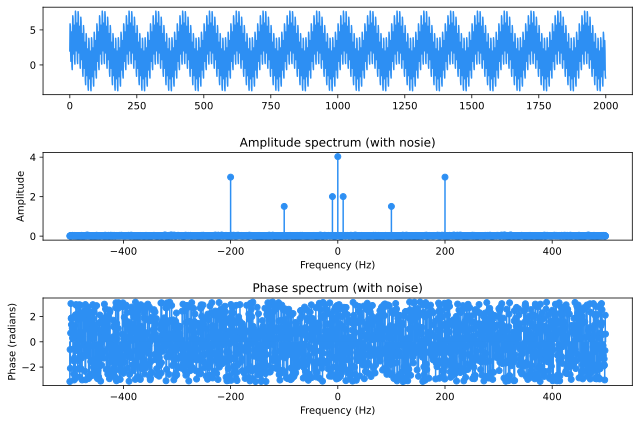

In [13]:
# (Part 2)

# Construct noisy signal
noise_amplitude = 0.5
noise = noise_amplitude * np.random.randn(N)
x_noisy = x + noise

# Repeat: Compute the Fourier transform
xf_noisy = fft(x_noisy)#[:N//2]
freqs_noisy = fftfreq(N, 1/fs)#[:N//2]  # Get positive frequencies

# Plot the magnitude and phase spectrum
xf_noisy_amplitude = 2/N * np.abs(xf_noisy)
xf_noisy_phase = np.angle(xf_noisy)
xf_noisy_phase[xf_noisy_amplitude < 1e-7] = 0

# 1. Visualize input signal x(t)
plt.figure(figsize=(9, 6))
plt.subplot(3, 1, 1)
plt.plot(x)

# 2. Plot amplitude spectrum
plt.subplot(3, 1, 2)
plt.stem(freqs_noisy, xf_noisy_amplitude)
plt.title('Amplitude spectrum (with nosie)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# 3. Plot phase spectrum
plt.subplot(3, 1, 3)
plt.stem(freqs_noisy, xf_noisy_phase)
plt.title('Phase spectrum (with noise)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')

# Use tight_layout to improve spacing of the subplots
plt.tight_layout()
plt.show()

---

<a id='exercise6'></a>

## **&#9734;&#9734; Exercise 6 – Fourier and aliasing**

This exercise demonstrates the effect of aliasing on the Fourier transform of a signal. Aliasing occurs when a signal is sampled at a rate lower than the Nyquist frequency (twice the highest frequency present in the signal), leading to distortions in the frequency domain.

### **Instructions**
- Construct a composite signal `x_noisy` similar to the previous example, including noise.
- Downsample the signal using a sampling frequency below the Nyquist limit (e.g., $fs=120\mathsf{Hz}$).
- Compute and compare the Fourier transform of both the original and downsampled signals.
- Analyze and visualize the impact of aliasing in the amplitude spectrum.
- Describe your observations


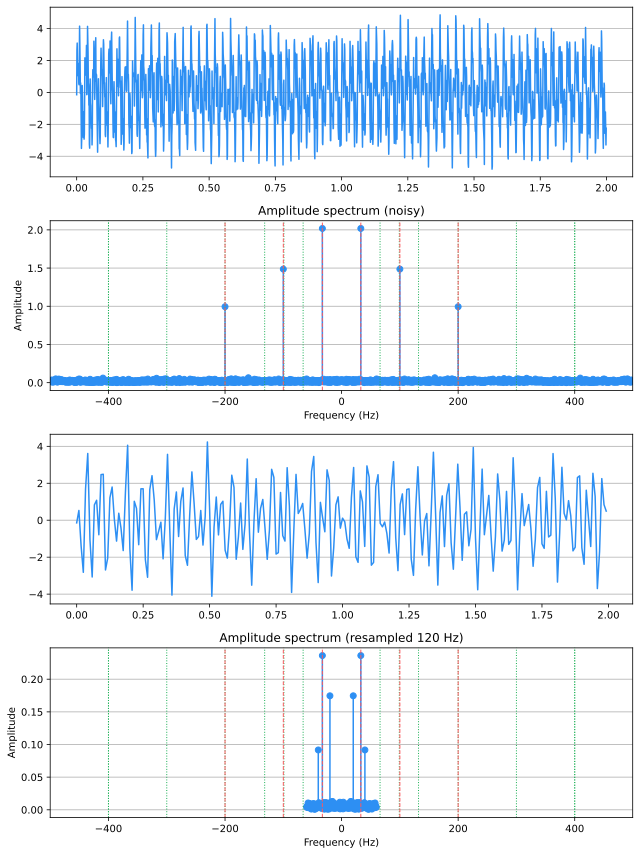

In [14]:
######################
###    EXERCISE    ###
######################



# # Generate composite signal with multiple harmonic components
f1 = 33  # Frequency of first harmonic (in Hz)
f2 = 100  # Frequency of second harmonic (in Hz)
f3 = 200  # Frequency of third harmonic (in Hz)

duration = 2
fs = 1000
t = np.arange(0, duration, 1/fs)  # Time vector
N = len(t)
noise_amplitude = 0.5
noise = noise_amplitude * np.random.randn(N)
x_noisy = (
    2 * np.sin(2 * np.pi * f1 * t) +
    1.5 * np.sin(2 * np.pi * f2 * t) +
    1 * np.sin(2 * np.pi * f3 * t)
) + noise

# Repeat: Compute the Fourier transform
xf_noisy = fft(x_noisy)#[:N//2]
freqs_noisy = fftfreq(N, 1/fs)#[:N//2]  # Get positive frequencies
xf_noisy_amplitude = 2/N * np.abs(xf_noisy)
#xf_noisy_phase = np.angle(xf_noisy)

# Resample at 120 Hz
fs_resampled = 120  # New sampling frequency
t_resampled = np.arange(0, duration, 1 / fs_resampled)  # New time vector
x_resampled = np.interp(t_resampled, t, x_noisy)  # Resample signal
N_resampled = len(x_resampled)

# Compute Fourier spectrum of the resampled signal
xf_resampled = np.fft.fft(x_resampled)
freqs_resampled = np.fft.fftfreq(N_resampled, 1 / fs_resampled)
xf_resampled = fftshift(xf_resampled)
freqs_resampled = fftshift(freqs_resampled)

# Extract amplitude
xf_resampled_amplitude = 2/N*np.abs(xf_resampled)

# Visualize original signal
plt.figure(figsize=(9, 12))
plt.subplot(4, 1, 1)
plt.plot(t, x_noisy)
plt.grid(True, axis="y")
plt.subplot(4, 1, 2)
plt.stem(freqs_noisy, xf_noisy_amplitude)
plt.title('Amplitude spectrum (noisy)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True, axis="y")
plt.xlim(freqs_noisy.min(), freqs_noisy.max())
#plt.ylim(0, None) 

# Highlight the main signal frequencies
col1 = isp.PALETTE[1]
col2 = isp.PALETTE[2]
for harmonic in [-f1, -f2, -f3] + [f1, f2, f3]:
    for i in range(2, 5):  # Repeat for higher harmonics
       plt.axvline(i * harmonic, color=col2, linestyle=':', linewidth=1)
    plt.axvline(harmonic, color=col1, linestyle='--', linewidth=1)

# Visualize resampled signal
#plt.figure(figsize=(9, 6))
plt.subplot(4, 1, 3)
plt.plot(t_resampled, x_resampled)
plt.grid(True, axis="y")
plt.subplot(4, 1, 4)
plt.stem(freqs_resampled,xf_resampled_amplitude)
plt.title('Amplitude spectrum (resampled 120 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(freqs_noisy.min(), freqs_noisy.max())
plt.grid(True, axis="y")

# Highlight the main signal frequencies
col1 = isp.PALETTE[1]
col2 = isp.PALETTE[2]
for harmonic in [-f1, -f2, -f3] + [f1, f2, f3]:
    for i in range(2, 5):  # Repeat for higher harmonics
       plt.axvline(i * harmonic, color=col2, linestyle=':', linewidth=1)
    plt.axvline(harmonic, color=col1, linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


When we resample the signal at $f_s=120\mathsf{Hz}$, the higher-frequency components (100 Hz and 200 Hz) are missing. This is a direct consequence of the Nyquist theorem, which states that the sampling frequency must be at least twice the highest frequency present in the signal to accurately reconstruct it.

Since our original signal contains components at 100 Hz and 200 Hz, but the sampling rate is only 120 Hz, these components are aliased into lower frequencies:

- The 100 Hz component is aliased to 20 Hz.
- The 200 Hz component is aliased to 40 Hz.

The alias frequencies can be computed as the difference between the original frequency and the nearest multiple of the sampling frequency. You can read more [about aliasing here](https://brianmcfee.net/dstbook-site/content/ch02-sampling/Aliasing.html)).

### **Key takeaways:**
- The resampled signal lacks important frequency information from the original signal.
- Worse, it introduces new frequencies (aliases) that were not present in the original signal.
- To prevent aliasing, we must apply a low-pass filter before downsampling, ensuring that no frequencies above half the sampling rate remain.